# 0. Preparation

In [44]:
# Import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statsmodels.tsa.seasonal import seasonal_decompose  # Seasonality
from statsmodels.graphics.tsaplots import plot_acf  # Autocorrelation
from scipy.interpolate import CubicSpline  # Spline Interpolation
from statsmodels.tsa.arima.model import ARIMA  # ARIMA

- About the dataset
  - US Counties COVID19 Dataset
    : This data comes from a public dataset by NYT, located in GitHub    
    (https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv)
  - Columns
      - county: Name of counties
      - state: Name of states
      - cases: number of COVID19 cases
      - deaths: total number of deaths due to COVID19

In [2]:
# Load dataset
data = pd.read_csv('./data/timeseries_us_covid19_2.csv', parse_dates=['ObservationDate'], index_col='ObservationDate')

data

,SNo,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
ObservationDate,,,,,,,
2020-01-22,1,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
2020-01-22,2,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2020-01-22,3,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
2020-01-22,4,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
2020-01-22,5,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2021-05-29,306425,Zaporizhia Oblast,Ukraine,2021-05-30 04:20:55,102641.0,2335.0,95289.0
2021-05-29,306426,Zeeland,Netherlands,2021-05-30 04:20:55,29147.0,245.0,0.0
2021-05-29,306427,Zhejiang,Mainland China,2021-05-30 04:20:55,1364.0,1.0,1324.0


In [3]:
# Drop unneccessary columns
data = data.drop(columns=['SNo', 'Province/State', 'Country/Region', 'Last Update', 'Recovered', 'Deaths'])

data

,Confirmed
ObservationDate,
2020-01-22,1.0
2020-01-22,14.0
2020-01-22,6.0
2020-01-22,1.0
2020-01-22,0.0
...,...
2021-05-29,102641.0
2021-05-29,29147.0
2021-05-29,1364.0


In [4]:
# Rename columns
data.rename(index={'ObservationDate': 'date'}, inplace=True)
data.rename(columns={'Confirmed': 'cases'}, inplace=True)

data

,cases
ObservationDate,
2020-01-22,1.0
2020-01-22,14.0
2020-01-22,6.0
2020-01-22,1.0
2020-01-22,0.0
...,...
2021-05-29,102641.0
2021-05-29,29147.0
2021-05-29,1364.0


In [5]:
data.describe()

,cases
count,3.064290e+05
mean,8.567091e+04
std,2.775516e+05
min,-3.028440e+05
25%,1.042000e+03
50%,1.037500e+04
75%,5.075200e+04
max,5.863138e+06


In [6]:
# Get number of missing values
missing_count = data.isnull().sum()

missing_count

cases    0
dtype: int64

In [7]:
# Convert 'date' to monthly period
data['per_month'] = data.index.to_period(freq='M')

# Convert 'per_month' to timestamp
data['per_month'] = data['per_month'].dt.to_timestamp()

data

,cases,per_month
ObservationDate,,
2020-01-22,1.0,2020-01-01
2020-01-22,14.0,2020-01-01
2020-01-22,6.0,2020-01-01
2020-01-22,1.0,2020-01-01
2020-01-22,0.0,2020-01-01
...,...,...
2021-05-29,102641.0,2021-05-01
2021-05-29,29147.0,2021-05-01
2021-05-29,1364.0,2021-05-01


# 1. Seasonality

In [8]:
# Create figure and axis objects
#fig, ax = plt.subplots()

# Plot using plot_date
#ax.plot_date(data['per_month'], data['cases'], '-', label='COVID-19 Cases')
#ax.plot_date(data['per_month'], data['deaths'], '-', label='Number of Deaths')

# Format the date axis
#ax.xaxis.set_major_locator(mdates.AutoDateLocator())
#ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(mdates.AutoDateLocator()))

# Rotate x-axis tick labels
#plt.xticks(rotation=45)

# Add labels and title
#ax.set_xlabel('Date')
#ax.set_ylabel('Number of Cases/Deaths')
#ax.set_title('Time Series - Seasonality')

# Add legend and adjust layout
#ax.legend()
#fig.tight_layout()

# Display the plot
#plt.show()


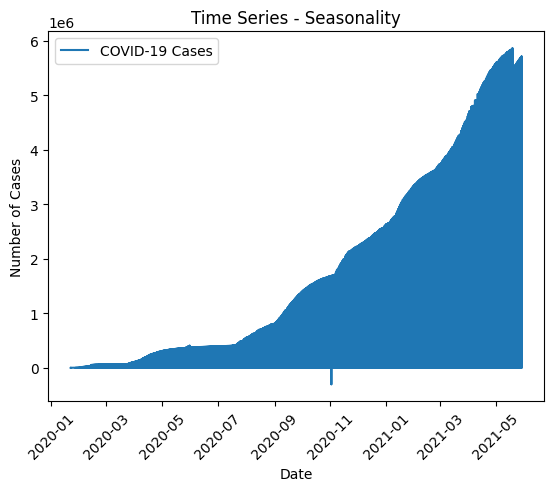

In [9]:
# Visualization
plt.plot(data.index, data['cases'], label='COVID-19 Cases')

plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.title('Time Series - Seasonality')

plt.xticks(rotation=45)
plt.legend()

plt.show()

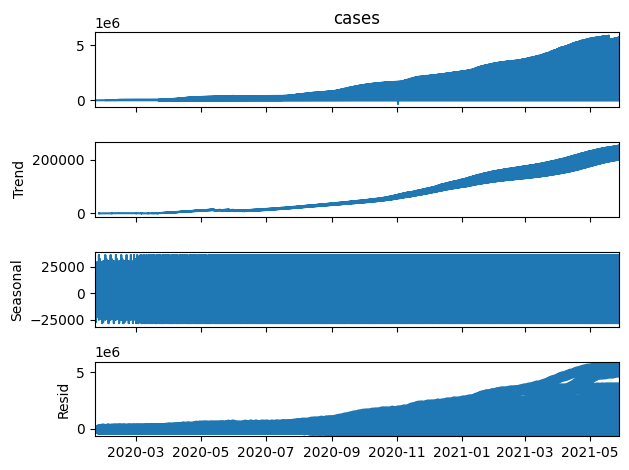

In [10]:
# Trend Analysis
result_cases = seasonal_decompose(data['cases'], model='Multiplicative', period=365)
result_cases.plot()
plt.show()

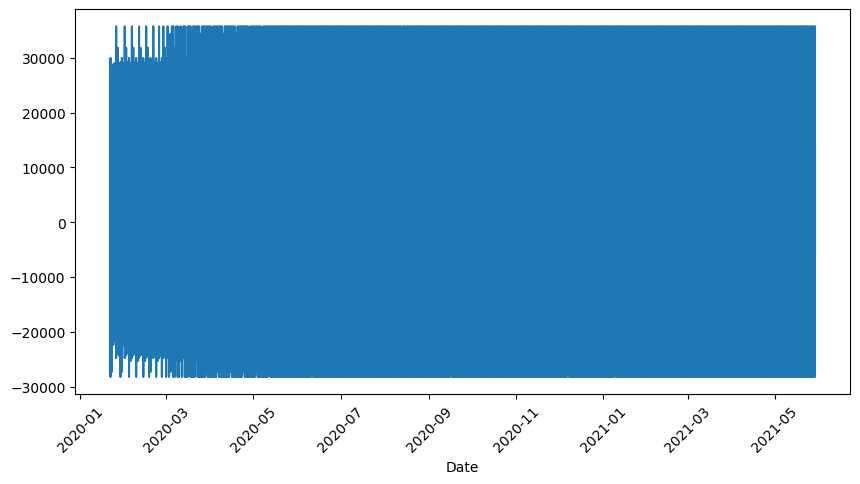

In [11]:
# Seasonality Analysis
seasonal_component = result_cases.seasonal

plt.figure(figsize=(10, 5))
plt.plot(seasonal_component)
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

# 2. Autocorrelation Function

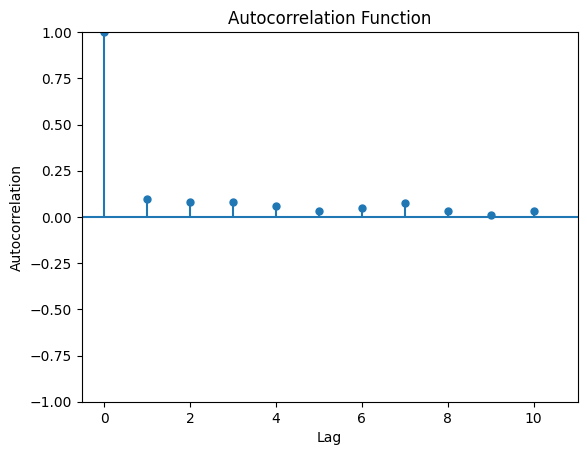

In [12]:
# Autocorrelation Function
plot_acf(data['cases'], lags=10)

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function')

plt.show()

# 3. Visualization

## 3.1. Line Plot

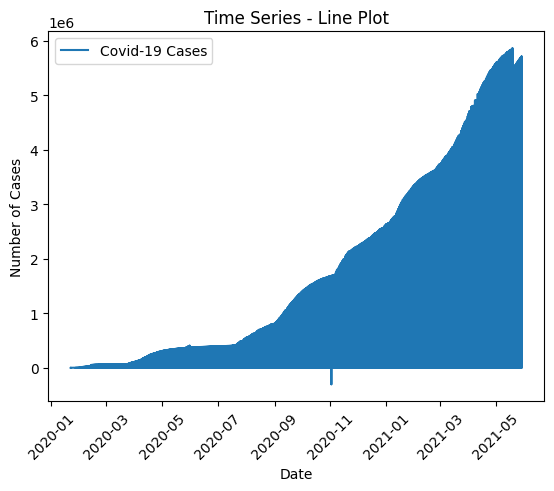

In [13]:
# Trends Line
plt.plot(data.index, data['cases'], label='Covid-19 Cases')

plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.title('Time Series - Line Plot')
plt.legend()
plt.xticks(rotation=45)

plt.show()

## 3.2. Scatter Plot

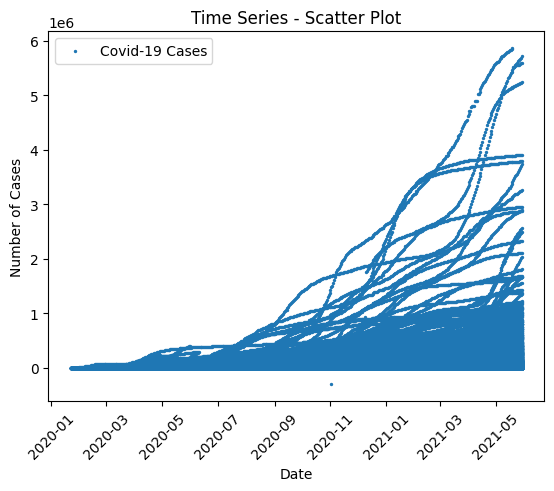

In [14]:
# Visualization
plt.scatter(data.index, data['cases'], s=2, label='Covid-19 Cases')

plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.title('Time Series - Scatter Plot')
plt.legend()
plt.xticks(rotation=45)

plt.show()

## 3.3. Bar Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


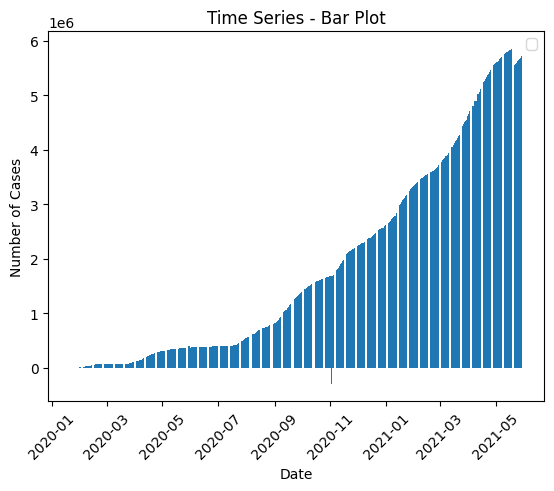

In [15]:
# Visualization
plt.bar(data.index, data['cases'])

plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.title('Time Series - Bar Plot')
plt.legend()
plt.xticks(rotation=45)

plt.show()

## 3.4. Box Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


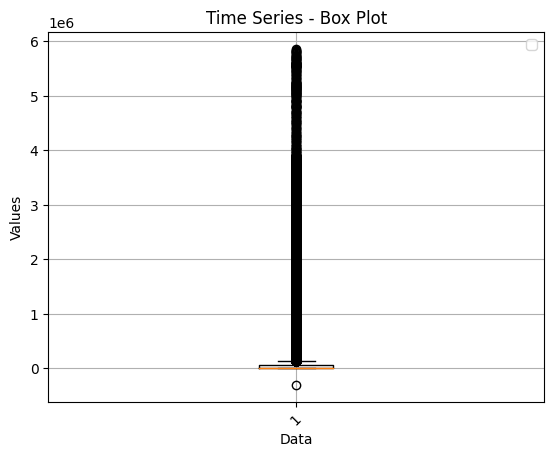

In [16]:
# Visualization
plt.boxplot(data['cases'])

plt.xlabel('Data')
plt.ylabel('Values')
plt.title('Time Series - Box Plot')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

plt.show()

## 3.5. Histogram

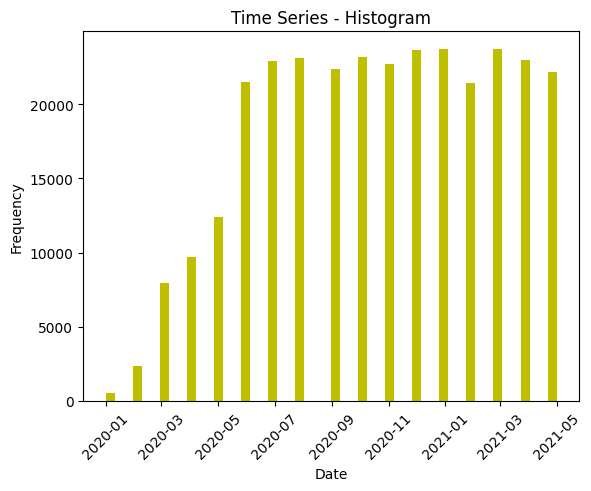

In [17]:
# Visaulization
plt.hist(data['per_month'], bins=50, color='y')

plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Time Series - Histogram')
plt.xticks(rotation=45)


plt.show()

## 3.6. Heatmap

## 3.7. Decomposition Plot

In [19]:
# Time Series Function
result = seasonal_decompose(data['cases'], model='additive', period=7)

# Create a dataframe
result_df = pd.DataFrame({
    'Date': data.index,
    'Original': data['cases'],
    
})

result_df

,Date,Original
ObservationDate,,
2020-01-22,2020-01-22,1.0
2020-01-22,2020-01-22,14.0
2020-01-22,2020-01-22,6.0
2020-01-22,2020-01-22,1.0
2020-01-22,2020-01-22,0.0
...,...,...
2021-05-29,2021-05-29,102641.0
2021-05-29,2021-05-29,29147.0
2021-05-29,2021-05-29,1364.0


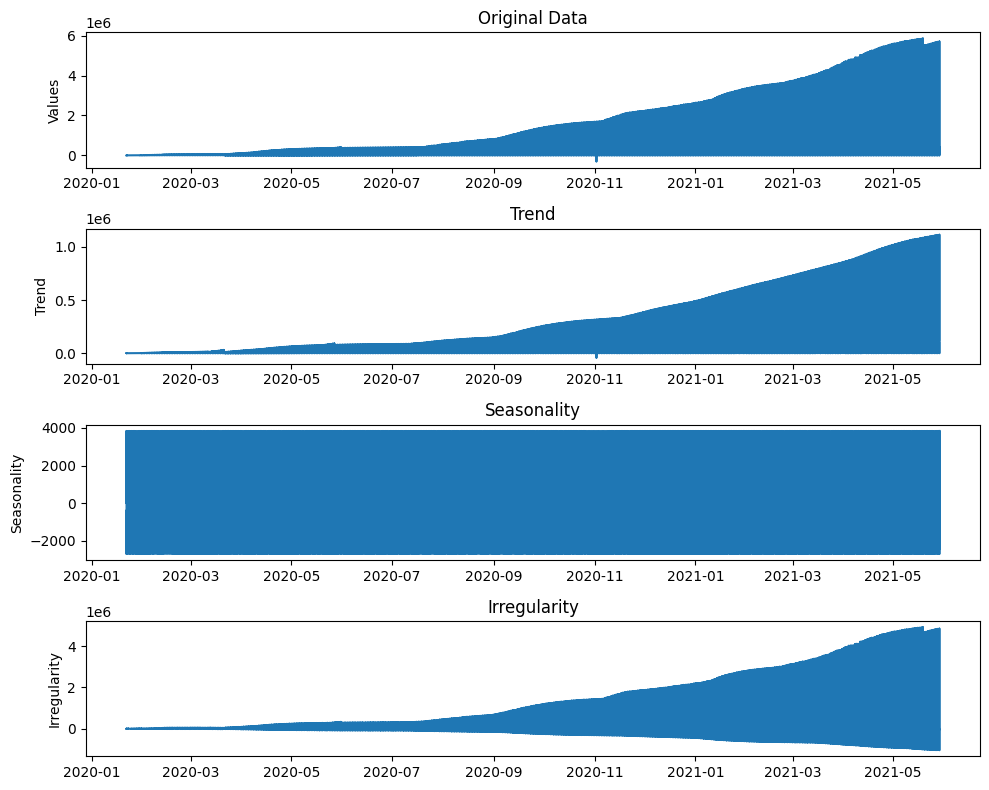

In [20]:
plt.figure(figsize=(10, 8))

# Visualization: Original
plt.subplot(4, 1, 1)
plt.plot(data.index, data['cases'])
plt.title('Original Data')
plt.ylabel('Values')

# Visualization: Trneds
plt.subplot(4, 1, 2)
plt.plot(data.index, result.trend)
plt.title('Trend')
plt.ylabel('Trend')

# Visualization: Seasonality
plt.subplot(4, 1, 3)
plt.plot(data.index, result.seasonal)
plt.title('Seasonality')
plt.ylabel('Seasonality')

# Visualization: Irregularity
plt.subplot(4, 1, 4)
plt.plot(data.index, result.resid)
plt.title('Irregularity')
plt.ylabel('Irregularity')

plt.tight_layout()
plt.show()

# 4. Pre-Processing

In [21]:
data2 = data.copy()

In [22]:
# Add missing values
data2.loc[data2.index[100:200], 'cases'] = np.nan
data2.loc[data2.index[1100:2200], 'cases'] = np.nan
data2.loc[data2.index[5100:7200], 'cases'] = np.nan
data2.loc[data2.index[10100:11200], 'cases'] = np.nan
data2.loc[data2.index[132100:142200], 'cases'] = np.nan
data2.loc[data2.index[191000:212000], 'cases'] = np.nan
data2.loc[data2.index[241000:252000], 'cases'] = np.nan
data2.loc[data2.index[281000:285200], 'cases'] = np.nan
data2.loc[data2.index[291100:291500], 'cases'] = np.nan
data2.loc[data2.index[300000:303400], 'cases'] = np.nan

In [23]:
data_temp = data2.copy()

In [24]:
# Get number of missing values
missing_count = data2.isnull().sum()

missing_count

cases        60113
per_month        0
dtype: int64

## 4.1. Find Missing Values

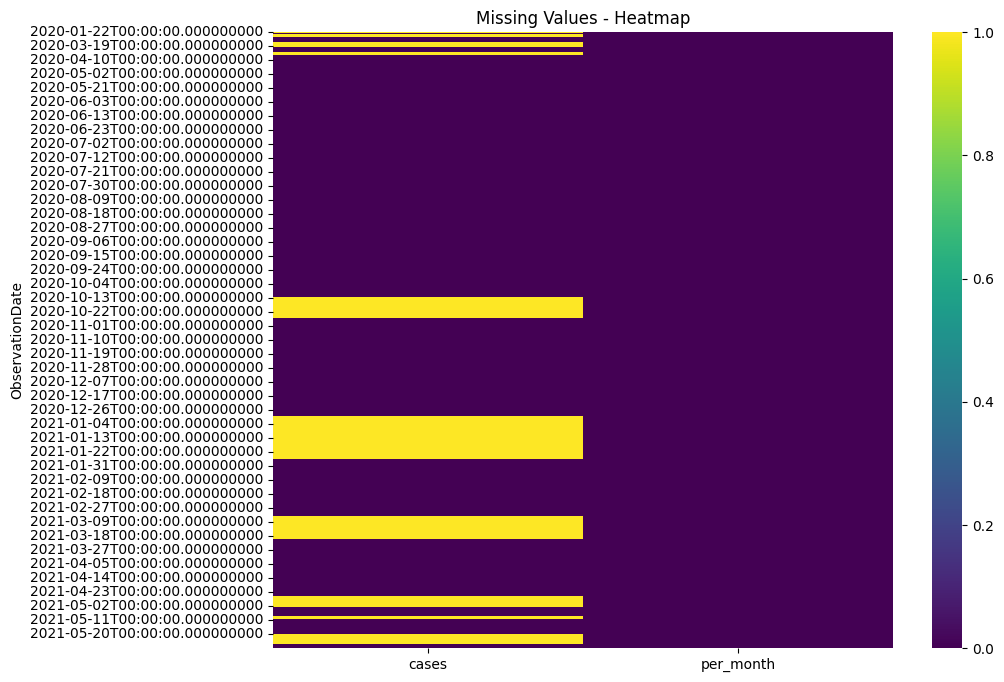

In [25]:
# Visualization: Heatmap
plt.figure(figsize=(10, 8))

sns.heatmap(data2.isnull(), cmap='viridis', cbar=True)
plt.title('Missing Values - Heatmap')

plt.show()

## 4.2. Linear Interpolation

In [26]:
# Linear Interpolation

data_temp['cases_filled'] = data_temp['cases'].interpolate(method='linear')

missing_count = data_temp.isnull().sum()
missing_count

cases           60113
per_month           0
cases_filled        0
dtype: int64

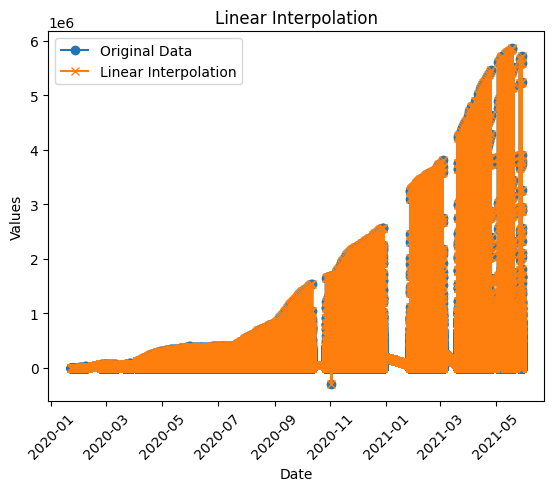

In [27]:
# Visualization
plt.plot(data_temp.index, data_temp['cases'], 'o-', label='Original Data')
plt.plot(data_temp.index, data_temp['cases_filled'], 'x-', label='Linear Interpolation')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Linear Interpolation')
plt.legend()
plt.xticks(rotation=45)

plt.show()

## 4.3. Spline Interpolation

In [30]:
# Check and sort the index if needed
if not data_temp.index.is_monotonic_increasing:
    data_temp = data_temp.sort_values(by='index')

# Reset the index if needed
if not isinstance(data_temp.index, pd.RangeIndex):
    data_temp = data_temp.reset_index(drop=True)

# Perform spline interpolation
spline = CubicSpline(data_temp.index, data_temp['cases_filled'])
data_temp['cases_spline'] = spline(data_temp.index)

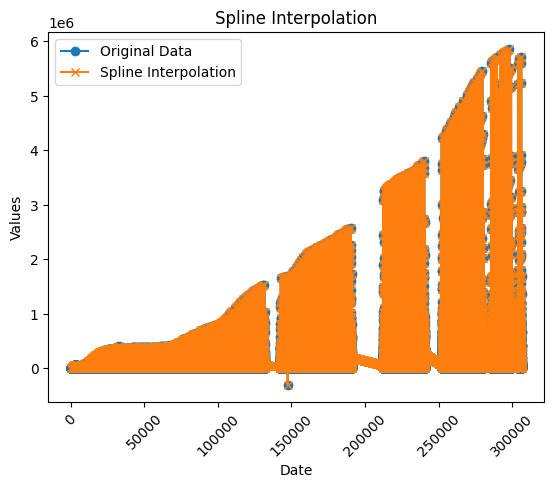

In [31]:
# Visualization
plt.plot(data_temp.index, data_temp['cases'], 'o-', label='Original Data')
plt.plot(data_temp.index, data_temp['cases_spline'], 'x-', label='Spline Interpolation')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Spline Interpolation')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## 4.4. Nearest Neighbor Interpolation

In [32]:
data_temp = data2.copy()

missing_count = data_temp.isnull().sum()
missing_count

cases        60113
per_month        0
dtype: int64

In [33]:
# Handle missing values: Nearest Neighbors Interpolation
data_temp['cases_nearest'] = data_temp['cases'].interpolate(method='nearest')

missing_count = data_temp.isnull().sum()
missing_count

cases            60113
per_month            0
cases_nearest        0
dtype: int64

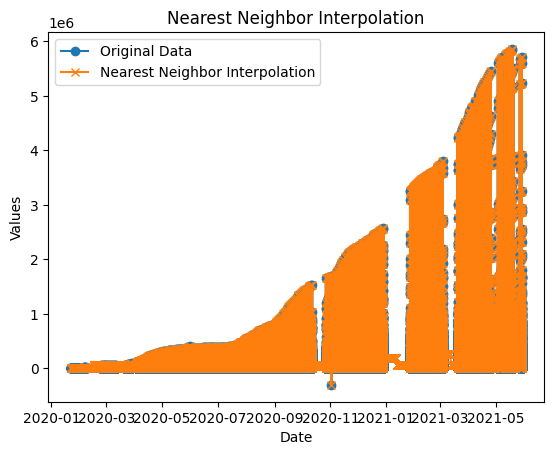

In [34]:
# Visualization
plt.plot(data_temp.index, data_temp['cases'], 'o-', label='Original Data')
plt.plot(data_temp.index, data_temp['cases_nearest'], 'x-', label='Nearest Neighbor Interpolation')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Nearest Neighbor Interpolation')
plt.legend()
plt.show()

## 4.5. Mean Imputation

In [36]:
data_temp = data2.copy()

missing_count = data_temp.isnull().sum()
missing_count

cases        60113
per_month        0
dtype: int64

In [38]:
# Handling missing values: Mean Imputation

# Get mean value
mean_value = data_temp['cases'].mean()
print('Mean Value: ', mean_value, '\n\n')

# Mean Inputation
data_temp['cases_imputated'] = data_temp['cases'].fillna(mean_value)

missing_count = data_temp.isnull().sum()
missing_count

Mean Value:  76902.87456356875 




cases              60113
per_month              0
cases_imputated        0
dtype: int64

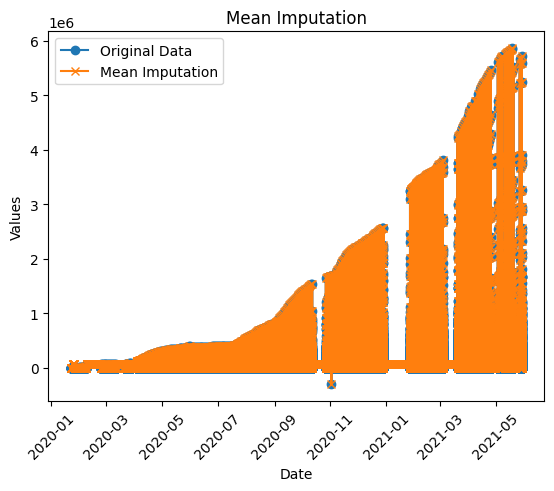

In [39]:
# Visualization
plt.plot(data_temp.index, data_temp['cases'], 'o-', label='Original Data')
plt.plot(data_temp.index, data_temp['cases_imputated'], 'x-', label='Mean Imputation')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Mean Imputation')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# 5. Time Series Data Models

## 5.1. ARIMA Model

In [51]:
data_temp = data2.copy()

missing_count = data_temp.isnull().sum()
missing_count

cases        60113
per_month        0
dtype: int64

In [52]:
# Get ARIMA model without missing values
model_arima = ARIMA(data_temp['cases'].dropna(), order=(1,  # Automagressive model
                                                          1,  # Degree of Difference
                                                          1)) # Moving Average

# Train the model
model_arima_fit = model_arima.fit()

C:\Users\genih\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\genih\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\genih\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [53]:
# Predict missing values
predicted_values = model_arima_fit.predict(start=100, end=len(data))

predicted_values

C:\Users\genih\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\genih\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


100           41.487394
101           41.367077
102           41.188602
103           41.195993
104           40.709571
              ...      
306425    214928.767716
306426    214928.767716
306427    214928.767716
306428    214928.767716
306429    214928.767716
Name: predicted_mean, Length: 306330, dtype: float64

In [54]:
data_temp.loc[data2.index[100:200], 'cases_arima'] = predicted_values
data_temp.loc[data2.index[1100:2200], 'cases_arima'] = predicted_values
data_temp.loc[data2.index[5100:7200], 'cases_arima'] = predicted_values
data_temp.loc[data2.index[10100:11200], 'cases_arima'] = predicted_values
data_temp.loc[data2.index[132100:142200], 'cases_arima'] = predicted_values
data_temp.loc[data2.index[191000:212000], 'cases_arima'] = predicted_values
data_temp.loc[data2.index[241000:252000], 'cases_arima'] = predicted_values
data_temp.loc[data2.index[281000:285200], 'cases_arima'] = predicted_values
data_temp.loc[data2.index[291100:291500], 'cases_arima'] = predicted_values
data_temp.loc[data2.index[300000:303400], 'cases_arima'] = predicted_values

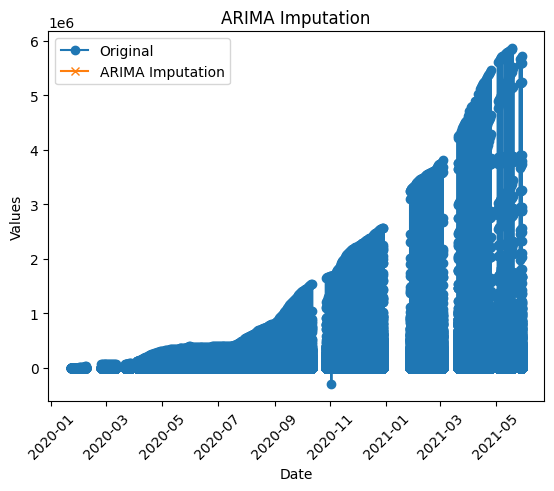

In [55]:
# Visualization
plt.plot(data_temp.index, data_temp['cases'], 'o-', label='Original')
plt.plot(data_temp.index, data_temp['cases_arima'], 'x-', label='ARIMA Imputation')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('ARIMA Imputation')
plt.legend()
plt.xticks(rotation=45)
plt.show()